In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pkg_resources
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gymnasium as gym
import stable_baselines3 as sb3
import stable_baselines3.common.logger as logger
import stable_baselines3.common.callbacks as callbacks
import stable_baselines3.common.env_checker as env_checker
from dm_control import mjcf
from dm_control.rl.control import PhysicsError
import imageio
import scipy.spatial
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric as pyg
import torch.nn.functional as F
import torch_geometric.nn as gnn
import torch_geometric.loader as pyg_loader
import pytorch_lightning as pl
import torchmetrics
from torch.utils.data import Dataset
from pathlib import Path
from typing import Tuple, Callable, Optional, List, Union
from tqdm import trange
from dm_control.rl.control import PhysicsError
from PIL import Image

from flygym.arena.mujoco_arena import FlatTerrain
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from flygym.state import stretched_pose
import flygym.util.vision as vision
import flygym.util.config as config
from flygym.arena import BaseArena
from flygym.arena.mujoco_arena import OdorArena, FlatTerrain, GappedTerrain, BlocksTerrain
from flygym.util.data import color_cycle_rgb

from rl_navigation import ObstacleOdorArena, NMFNavigation

pygame 2.5.1 (SDL 2.28.2, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/lightning_fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning_fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site

In [3]:
terrain_arena = FlatTerrain(ground_alpha=1)
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    obstacle_positions=np.array([(10, 0)]),
    obstacle_radius=1.5,
    odor_source=np.array([[20, 0, 2]]),
    marker_size=0.5,
    obstacle_colors=(0.14, 0.14, 0.2, 1),
)
sim = NMFNavigation(
    arena=arena,
    test_mode=True,
    debug_mode=True,
)
# env_checker.check_env(sim)

/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


resetting environment


In [4]:
# from flygym.util.vision import hex_pxls_to_human_readable

terrain_arena = FlatTerrain(ground_alpha=1)
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    obstacle_positions=np.array([(7.5, 0)]),
    obstacle_radius=1.5,
    odor_source=np.array([[15, 0, 2]]),
    marker_size=0.5,
    obstacle_colors=(0, 0, 0, 1),
)
sim = NMFNavigation(
    spawn_pos=(7.5, -10, 0.2),
    spawn_orient=(0, 0, 1, np.pi/4),
    arena=arena,
    test_mode=True,
    debug_mode=True,
)

obs_hist = []
reward_hist = []
action_hist = []
obs, info = sim.reset()
for i in trange(15):
    action = np.array([0 if i < 10 else 0.6])
    action_hist.append(action)
    obs, reward, terminated, truncated, info = sim.step(action)
    # fig, axs = plt.subplots(1, 2, figsize=(4, 2))
    # for i in range(2):
    #     visual_inputs = sim.curr_visual_input[i, :, :]
    #     print(visual_inputs.shape, visual_inputs.max())
    #     visual_inputs[:, 1] = 0
    #     visual_inputs[:, 0][visual_inputs[:, 0] > 50] = 0
    #     img = hex_pxls_to_human_readable(visual_inputs)
    #     axs[i].imshow(img, cmap="gray", vmin=0, vmax=255)
    #     axs[i].axis("off")
    # plt.show()
    
    obs_hist.append(obs)
    reward_hist.append(reward)
    if terminated:
        print("terminated")
        break

obs_hist = np.array(obs_hist)
reward_hist = np.array(reward_hist)
action_hist = np.array(action_hist)

sim.save_video("test2.mp4")

resetting environment
resetting environment


  7%|▋         | 1/15 [00:01<00:16,  1.19s/it]

fly_pos: [  7.52433713 -10.06858912], final reward=3.2918658708870163, state=seeking
  dist rew=2.459584, danger=0.000, action diff=0.000, tgt rew=0.832
  dist=12.540


 13%|█▎        | 2/15 [00:02<00:17,  1.37s/it]

fly_pos: [  7.98586545 -10.1912249 ], final reward=1.024513694695472, state=seeking
  dist rew=0.168708, danger=0.000, action diff=0.000, tgt rew=0.856
  dist=12.372


 20%|██        | 3/15 [00:04<00:18,  1.50s/it]

fly_pos: [ 8.40695182 -9.82164435], final reward=1.3534581918164128, state=seeking
  dist rew=0.542380, danger=0.000, action diff=0.000, tgt rew=0.811
  dist=11.829


 27%|██▋       | 4/15 [00:05<00:16,  1.47s/it]

fly_pos: [ 8.45937769 -9.42266703], final reward=1.2277304285903976, state=seeking
  dist rew=0.359088, danger=0.000, action diff=0.000, tgt rew=0.869
  dist=11.470


 33%|███▎      | 5/15 [00:07<00:14,  1.47s/it]

fly_pos: [ 8.80349968 -9.09149614], final reward=1.4351247783402394, state=seeking
  dist rew=0.467880, danger=0.000, action diff=0.000, tgt rew=0.967
  dist=11.002


 40%|████      | 6/15 [00:08<00:13,  1.46s/it]

fly_pos: [ 8.98602125 -8.69039795], final reward=1.3118851006085808, state=seeking
  dist rew=0.433965, danger=0.000, action diff=0.000, tgt rew=0.878
  dist=10.568


 47%|████▋     | 7/15 [00:10<00:11,  1.48s/it]

fly_pos: [ 9.36583967 -8.30584844], final reward=1.5067469416035326, state=seeking
  dist rew=0.531917, danger=0.000, action diff=0.000, tgt rew=0.975
  dist=10.036


 53%|█████▎    | 8/15 [00:11<00:10,  1.46s/it]

fly_pos: [ 9.64914389 -7.95755984], final reward=1.4332077673043595, state=seeking
  dist rew=0.447191, danger=0.000, action diff=0.000, tgt rew=0.986
  dist=9.589


 60%|██████    | 9/15 [00:13<00:08,  1.47s/it]

fly_pos: [ 9.9514733  -7.56625194], final reward=1.4182478760702475, state=seeking
  dist rew=0.493365, danger=0.000, action diff=0.000, tgt rew=0.925
  dist=9.096


 67%|██████▋   | 10/15 [00:14<00:07,  1.45s/it]

fly_pos: [10.34001934 -7.0735791 ], final reward=1.5970419429082825, state=seeking
  dist rew=0.625329, danger=0.000, action diff=0.000, tgt rew=0.972
  dist=8.471


 73%|███████▎  | 11/15 [00:16<00:05,  1.47s/it]

fly_pos: [10.50899285 -6.75471007], final reward=0.896714177480135, state=seeking
  dist rew=0.359165, danger=0.000, action diff=0.300, tgt rew=0.838
  dist=8.111


 80%|████████  | 12/15 [00:17<00:04,  1.52s/it]

fly_pos: [11.19805884 -6.88096019], final reward=1.008532338356809, state=seeking
  dist rew=0.249979, danger=0.000, action diff=0.000, tgt rew=0.759
  dist=7.861


 87%|████████▋ | 13/15 [00:19<00:02,  1.48s/it]

fly_pos: [11.21781091 -6.69538117], final reward=0.846355690499204, state=seeking
  dist rew=0.171644, danger=0.000, action diff=0.000, tgt rew=0.675
  dist=7.690


 93%|█████████▎| 14/15 [00:20<00:01,  1.53s/it]

fly_pos: [11.71397657 -6.5465504 ], final reward=0.9553854340111835, state=seeking
  dist rew=0.364828, danger=0.000, action diff=0.000, tgt rew=0.591
  dist=7.325


100%|██████████| 15/15 [00:22<00:00,  1.47s/it]

fly_pos: [11.9525489  -6.85133623], final reward=0.32009318908986173, state=seeking
  dist rew=-0.173542, danger=0.000, action diff=0.000, tgt rew=0.494
  dist=7.499


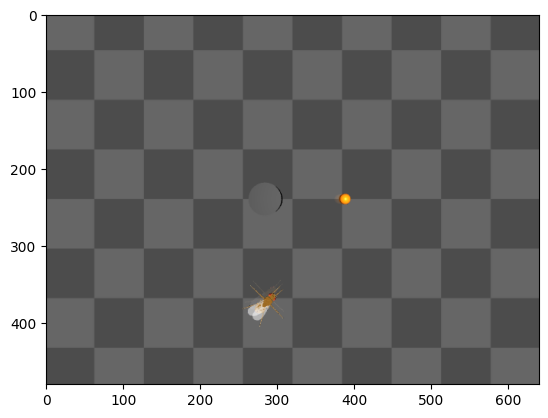

In [5]:
plt.imshow(sim._frames[0])

resetting environment
Logging to logs/trial_8
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
resetting environment


  1%|          | 1/100 [00:01<03:06,  1.88s/it]

fly_pos: [ 0.06946828 -0.10582025], final reward=-0.9421552379460656, state=seeking
  dist rew=0.069093, danger=0.711, action diff=0.301, tgt rew=0.000
  dist=14.931


  2%|▏         | 2/100 [00:03<03:08,  1.92s/it]

fly_pos: [ 0.33449045 -0.46805576], final reward=-1.0244382139326795, state=seeking
  dist rew=0.257930, danger=0.603, action diff=0.680, tgt rew=0.000
  dist=14.673


  3%|▎         | 3/100 [00:05<02:54,  1.80s/it]

fly_pos: [ 0.50843833 -0.28448916], final reward=-0.5492692603711218, state=seeking
  dist rew=0.178623, danger=0.527, action diff=0.201, tgt rew=0.000
  dist=14.494


  4%|▍         | 4/100 [00:07<03:01,  1.89s/it]

fly_pos: [ 0.83081021 -0.28990829], final reward=-0.2603507466233883, state=seeking
  dist rew=0.322199, danger=0.527, action diff=0.055, tgt rew=0.000
  dist=14.172


  5%|▌         | 5/100 [00:09<02:54,  1.84s/it]

fly_pos: [ 1.17151845 -0.37063854], final reward=0.030094284888948497, state=seeking
  dist rew=0.338708, danger=0.238, action diff=0.071, tgt rew=0.000
  dist=13.833


  6%|▌         | 6/100 [00:11<02:52,  1.83s/it]

fly_pos: [ 1.39463039 -0.37734462], final reward=0.19647477988707962, state=seeking
  dist rew=0.222846, danger=0.000, action diff=0.026, tgt rew=0.000
  dist=13.611


  7%|▋         | 7/100 [00:12<02:45,  1.78s/it]

fly_pos: [ 1.6541319  -0.84938218], final reward=0.10902151688418904, state=seeking
  dist rew=0.237732, danger=0.000, action diff=0.129, tgt rew=0.000
  dist=13.373


  8%|▊         | 8/100 [00:14<02:43,  1.77s/it]

fly_pos: [ 1.69333259 -0.67388166], final reward=-0.24296764079437239, state=seeking
  dist rew=0.049150, danger=0.000, action diff=0.292, tgt rew=0.000
  dist=13.324


  9%|▉         | 9/100 [00:16<02:37,  1.73s/it]

fly_pos: [ 2.18752437 -0.9634633 ], final reward=0.41923240184225463, state=seeking
  dist rew=0.475071, danger=0.000, action diff=0.056, tgt rew=0.000
  dist=12.849


 10%|█         | 10/100 [00:17<02:31,  1.68s/it]

fly_pos: [ 2.48893981 -1.12142987], final reward=0.1353353222701763, state=seeking
  dist rew=0.287430, danger=0.000, action diff=0.152, tgt rew=0.000
  dist=12.561


 11%|█         | 11/100 [00:19<02:30,  1.69s/it]

fly_pos: [ 2.55763961 -0.83578265], final reward=-0.014566550833373881, state=seeking
  dist rew=0.090820, danger=0.000, action diff=0.105, tgt rew=0.000
  dist=12.470


 12%|█▏        | 12/100 [00:20<02:18,  1.57s/it]

fly_pos: [ 2.68056868 -1.27766087], final reward=-0.3123705797316454, state=seeking
  dist rew=0.084892, danger=0.000, action diff=0.397, tgt rew=0.000
  dist=12.386


 13%|█▎        | 13/100 [00:22<02:15,  1.55s/it]

fly_pos: [ 2.97575856 -1.59091218], final reward=0.23329051407502988, state=seeking
  dist rew=0.256477, danger=0.000, action diff=0.023, tgt rew=0.000
  dist=12.129


 14%|█▍        | 14/100 [00:23<02:16,  1.59s/it]

fly_pos: [ 3.21628648 -1.83844032], final reward=-0.0068134644728665705, state=seeking
  dist rew=0.202767, danger=0.000, action diff=0.210, tgt rew=0.000
  dist=11.926


 15%|█▌        | 15/100 [00:25<02:15,  1.60s/it]

fly_pos: [ 3.53835111 -2.00598407], final reward=0.13198087715913331, state=seeking
  dist rew=0.290398, danger=0.000, action diff=0.158, tgt rew=0.000
  dist=11.636


 16%|█▌        | 16/100 [00:27<02:12,  1.57s/it]

fly_pos: [ 3.83840432 -2.16787304], final reward=0.19659367179419185, state=seeking
  dist rew=0.265690, danger=0.000, action diff=0.069, tgt rew=0.000
  dist=11.370


 17%|█▋        | 17/100 [00:28<02:05,  1.52s/it]

fly_pos: [ 4.17298175 -2.46817744], final reward=0.1613317335850315, state=seeking
  dist rew=0.265392, danger=0.000, action diff=0.104, tgt rew=0.000
  dist=11.105


 18%|█▊        | 18/100 [00:29<02:02,  1.49s/it]

fly_pos: [ 4.6571224  -2.69326607], final reward=0.37818536138083125, state=seeking
  dist rew=0.416996, danger=0.000, action diff=0.039, tgt rew=0.000
  dist=10.688


 19%|█▉        | 19/100 [00:31<02:00,  1.49s/it]

fly_pos: [ 4.97320814 -2.99391646], final reward=0.11568209582883071, state=seeking
  dist rew=0.223558, danger=0.000, action diff=0.108, tgt rew=0.000
  dist=10.464


 20%|██        | 20/100 [00:32<02:00,  1.51s/it]

fly_pos: [ 5.47195659 -3.16668871], final reward=0.4038355665376461, state=seeking
  dist rew=0.423735, danger=0.000, action diff=0.020, tgt rew=0.000
  dist=10.040


 21%|██        | 21/100 [00:34<01:58,  1.50s/it]

fly_pos: [ 5.72997193 -3.29813171], final reward=0.1157289198474647, state=seeking
  dist rew=0.201232, danger=0.000, action diff=0.086, tgt rew=0.000
  dist=9.839


 22%|██▏       | 22/100 [00:35<01:59,  1.53s/it]

fly_pos: [ 5.83091157 -3.46786123], final reward=-0.06451017620087107, state=seeking
  dist rew=0.036292, danger=0.000, action diff=0.101, tgt rew=0.000
  dist=9.803


 23%|██▎       | 23/100 [00:37<01:59,  1.55s/it]

fly_pos: [ 6.35606412 -3.3352045 ], final reward=0.3740689731520632, state=seeking
  dist rew=0.537918, danger=0.000, action diff=0.164, tgt rew=0.000
  dist=9.265


 24%|██▍       | 24/100 [00:39<01:59,  1.57s/it]

fly_pos: [ 6.5209659  -3.39725071], final reward=0.10599096239042893, state=seeking
  dist rew=0.130759, danger=0.000, action diff=0.025, tgt rew=0.000
  dist=9.134


 25%|██▌       | 25/100 [00:40<02:00,  1.60s/it]

fly_pos: [ 7.04820348 -3.41297743], final reward=0.4082731633610788, state=seeking
  dist rew=0.481001, danger=0.000, action diff=0.073, tgt rew=0.000
  dist=8.653


 26%|██▌       | 26/100 [00:42<01:58,  1.60s/it]

fly_pos: [ 7.35886778 -3.44368095], final reward=0.24678350955946016, state=seeking
  dist rew=0.272014, danger=0.000, action diff=0.025, tgt rew=0.000
  dist=8.381


 27%|██▋       | 27/100 [00:43<01:53,  1.56s/it]

fly_pos: [ 7.68822816 -3.53296074], final reward=0.7483959027103984, state=seeking
  dist rew=0.260699, danger=0.000, action diff=0.005, tgt rew=0.493
  dist=8.121


 28%|██▊       | 28/100 [00:45<01:52,  1.56s/it]

fly_pos: [ 8.23084405 -3.4194015 ], final reward=0.9741374636202138, state=seeking
  dist rew=0.536796, danger=0.000, action diff=0.008, tgt rew=0.445
  dist=7.584


 29%|██▉       | 29/100 [00:47<01:52,  1.59s/it]

fly_pos: [ 8.44215842 -3.47866681], final reward=0.5272866670449368, state=seeking
  dist rew=0.160415, danger=0.000, action diff=0.195, tgt rew=0.562
  dist=7.423


 30%|███       | 30/100 [00:48<01:52,  1.61s/it]

fly_pos: [ 8.93177462 -3.45221062], final reward=0.6899037213878398, state=seeking
  dist rew=0.441885, danger=0.000, action diff=0.218, tgt rew=0.466
  dist=6.981


 31%|███       | 31/100 [00:50<01:49,  1.59s/it]

fly_pos: [ 8.99024987 -3.54160707], final reward=0.39681378724369365, state=seeking
  dist rew=0.005806, danger=0.000, action diff=0.148, tgt rew=0.539
  dist=6.976


 32%|███▏      | 32/100 [00:51<01:48,  1.60s/it]

fly_pos: [ 9.20239541 -3.42009473], final reward=0.5639906895047905, state=seeking
  dist rew=0.244462, danger=0.000, action diff=0.296, tgt rew=0.615
  dist=6.731


 33%|███▎      | 33/100 [00:53<01:50,  1.64s/it]

fly_pos: [ 9.63458388 -3.22674332], final reward=0.8021308398775147, state=seeking
  dist rew=0.470260, danger=0.000, action diff=0.295, tgt rew=0.627
  dist=6.261


 34%|███▍      | 34/100 [00:55<01:50,  1.67s/it]

fly_pos: [ 9.90471415 -3.22004862], final reward=0.9010287417622098, state=seeking
  dist rew=0.233464, danger=0.000, action diff=0.029, tgt rew=0.696
  dist=6.027


 35%|███▌      | 35/100 [00:57<01:51,  1.72s/it]

fly_pos: [10.31870557 -2.97443926], final reward=0.9046949030384648, state=seeking
  dist rew=0.481159, danger=0.000, action diff=0.286, tgt rew=0.710
  dist=5.546


 36%|███▌      | 36/100 [00:58<01:49,  1.72s/it]

fly_pos: [10.4782359 -2.9347165], final reward=0.9345340221791084, state=seeking
  dist rew=0.155701, danger=0.000, action diff=0.046, tgt rew=0.825
  dist=5.391


 37%|███▋      | 37/100 [01:00<01:47,  1.71s/it]

fly_pos: [10.9154011  -2.74071872], final reward=1.1597820049656062, state=seeking
  dist rew=0.471741, danger=0.000, action diff=0.118, tgt rew=0.784
  dist=4.919


 38%|███▊      | 38/100 [01:02<01:46,  1.72s/it]

fly_pos: [10.7501379  -2.43990377], final reward=0.4944752207386508, state=seeking
  dist rew=0.018436, danger=0.000, action diff=0.205, tgt rew=0.680
  dist=4.900


 39%|███▉      | 39/100 [01:03<01:40,  1.66s/it]

fly_pos: [10.70451727 -2.2086055 ], final reward=0.16493228891524692, state=seeking
  dist rew=0.070433, danger=0.000, action diff=0.566, tgt rew=0.653
  dist=4.830


 40%|████      | 40/100 [01:05<01:30,  1.51s/it]

fly_pos: [11.15650416 -2.13319109], final reward=1.0014017210923394, state=seeking
  dist rew=0.434232, danger=0.000, action diff=0.354, tgt rew=0.764
  dist=4.396


 41%|████      | 41/100 [01:06<01:24,  1.44s/it]

fly_pos: [11.62245122 -2.47264023], final reward=0.6482990475806287, state=seeking
  dist rew=0.209886, danger=0.000, action diff=0.274, tgt rew=0.610
  dist=4.186


 42%|████▏     | 42/100 [01:08<01:29,  1.54s/it]

fly_pos: [11.80245867 -2.18783279], final reward=1.0299055265569832, state=seeking
  dist rew=0.311515, danger=0.000, action diff=0.130, tgt rew=0.638
  dist=3.874


 43%|████▎     | 43/100 [01:10<01:33,  1.64s/it]

fly_pos: [12.00875079 -2.22606688], final reward=0.9488474472160391, state=seeking
  dist rew=0.145723, danger=0.000, action diff=0.045, tgt rew=0.737
  dist=3.729


 44%|████▍     | 44/100 [01:12<01:38,  1.76s/it]

fly_pos: [12.51409024 -1.87217472], final reward=2.012617600449557, state=seeking
  dist rew=0.616627, danger=0.000, action diff=0.024, tgt rew=0.721
  dist=3.112


 45%|████▌     | 45/100 [01:13<01:33,  1.71s/it]

fly_pos: [12.59802677 -1.95699318], final reward=0.6885628749704736, state=seeking
  dist rew=0.013765, danger=0.000, action diff=0.069, tgt rew=0.728
  dist=3.098


 46%|████▌     | 46/100 [01:15<01:32,  1.71s/it]

fly_pos: [12.51572819 -2.27118627], final reward=0.45538446638750185, state=seeking
  dist rew=-0.267717, danger=0.000, action diff=0.000, tgt rew=0.986
  dist=3.366


 46%|████▌     | 46/100 [01:16<01:30,  1.67s/it]

fly_pos: [12.69575375 -1.7885542 ], final reward=30.97025995818636, state=success
  dist rew=0.449061, danger=0.000, action diff=0.000, tgt rew=0.970
  dist=2.917
terminated
terminated


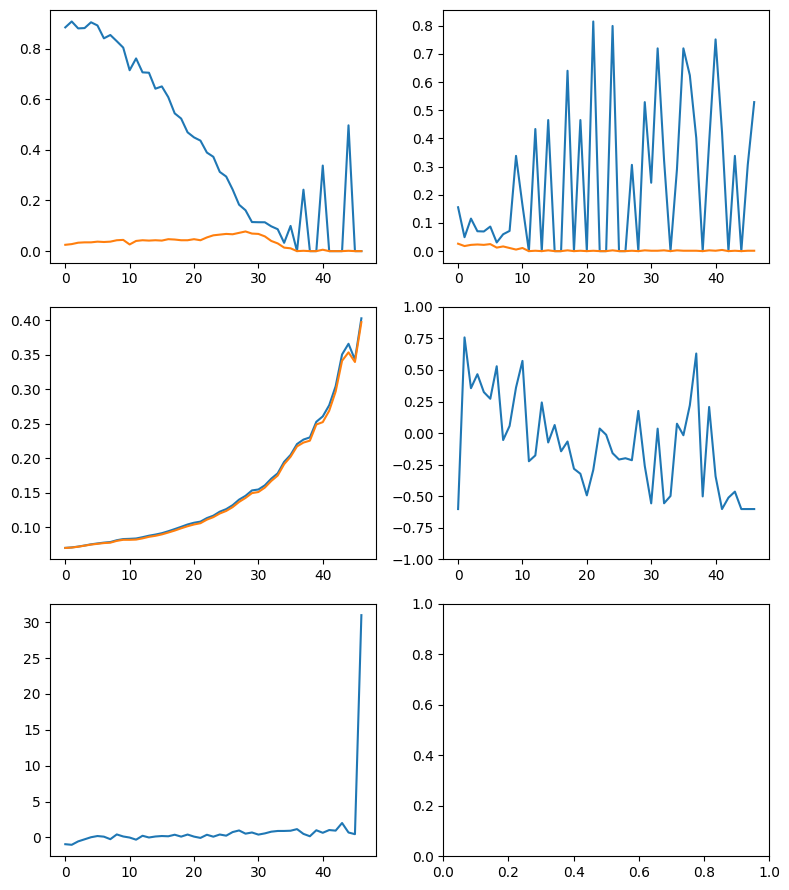

In [6]:
terrain_arena = FlatTerrain(ground_alpha=1)
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    obstacle_positions=np.array([(7.5, 0)]),
    obstacle_radius=1,
    odor_source=np.array([[15, 0, 2]]),
    marker_size=0.5,
    obstacle_colors=(0, 0, 0, 1),
)
sim = NMFNavigation(
    arena=arena,
    test_mode=True,
    debug_mode=True,
)

np.random.seed(0)
sb3.common.utils.set_random_seed(0, using_cuda=True)

start_from = "logs/trial_17d/trial_17d_199200_steps.zip"
train = False

log_dir = "logs/trial_8"
checkpoint_callback = callbacks.CheckpointCallback(
    save_freq=100,
    save_path=log_dir,
    name_prefix="trial_8",
    save_replay_buffer=True,
    save_vecnormalize=True,
    verbose=2,
)
my_logger = logger.configure(log_dir, ["tensorboard", "stdout", "csv"])
model = sb3.SAC(
    "MlpPolicy",
    # env=sim,
    env=sim,
    policy_kwargs={"net_arch": [16, 16]},
    verbose=2,
    learning_rate=0.01,
)
if start_from is not None:
    model = sb3.SAC.load(start_from)
model.set_logger(my_logger)

if train:
    model.learn(total_timesteps=50_000, progress_bar=True, callback=checkpoint_callback)
    model.save("models/trial_8")

obs_hist = []
reward_hist = []
action_hist = []
obs, info = sim.reset()
for i in trange(100):
    action, _ = model.predict(obs, deterministic=True)    
    obs, reward, terminated, truncated, info = sim.step(action)
    action_hist.append(action)
    obs_hist.append(obs)
    reward_hist.append(reward)
    if terminated:
        print("terminated")
        break

obs_hist = np.array(obs_hist)
reward_hist = np.array(reward_hist)
action_hist = np.array(action_hist)

sim.save_video(Path(start_from).stem + ".mp4")

fig, axs = plt.subplots(3, 2, figsize=(8, 9), tight_layout=True)
axs[0, 0].plot(obs_hist[:, 0])
axs[0, 0].plot(obs_hist[:, 1])
axs[0, 1].plot(obs_hist[:, 2])
axs[0, 1].plot(obs_hist[:, 3])
axs[1, 0].plot(obs_hist[:, 4])
axs[1, 0].plot(obs_hist[:, 5])
axs[1, 1].plot(action_hist)
axs[1, 1].set_ylim(-1, 1)
axs[2, 0].plot(reward_hist)